In [105]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import math

torch.manual_seed(0)

In [106]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mu = torch.tensor(0.01)

In [107]:
class DeepONet(nn.Module):
    def __init__(self):
        super(DeepONet,self).__init__()
        self.Branch_L1 = nn.Linear(201,100)
        self.Branch_L2 = nn.Linear(100,100)
        self.Branch_L3 = nn.Linear(100,100)
        self.Branch_L4 = nn.Linear(100,100)
        self.Branch_L5 = nn.Linear(100,100)
        self.Branch_L6 = nn.Linear(100,100)
        self.Branch_L7 = nn.Linear(100,100)

        self.Trunk_L1 = nn.Linear(2,20)
        self.Trunk_L2 = nn.Linear(20,20)
        self.Trunk_L3 = nn.Linear(20,20)
        self.Trunk_L4 = nn.Linear(20,20)
        self.Trunk_L5 = nn.Linear(20,100)

    def forward(self,y_0,x_loc_and_time):
        # Branch
        b = F.tanh(self.Branch_L1(y_0))
        b = F.tanh(self.Branch_L2(b))
        b = F.tanh(self.Branch_L3(b))
        b = F.tanh(self.Branch_L4(b))
        b = F.tanh(self.Branch_L5(b))
        b = F.tanh(self.Branch_L6(b))
        b = self.Branch_L7(b)

        tr = F.tanh(self.Trunk_L1(x_loc_and_time))
        tr = F.tanh(self.Trunk_L2(tr))
        tr = F.tanh(self.Trunk_L3(tr))
        tr = F.tanh(self.Trunk_L4(tr))
        tr = self.Trunk_L5(tr)

        #output = torch.matmul(b,tr.t()).sum(dim=0)
        output = torch.sum(b * tr, dim=1)

        return output
    
model = torch.load("model_burgers_1.pt",weights_only=False)

model = DeepONet().to(device)

In [108]:
database = pd.read_csv('minus_sin_pix.csv',index_col=0).dropna().to_numpy(dtype='float32')

In [109]:
database.shape

(201201, 204)

In [110]:
class Data(Dataset):
    def __init__(self,transform=None):
        self.initial_conditions = torch.from_numpy(database[:,0:201])#.requires_grad_(True)
        self.x_location = torch.from_numpy(database[:,[201]])#.requires_grad_(True)
        self.time_vale = torch.from_numpy(database[:,[202]]).requires_grad_(True)
        self.true_y_value = torch.from_numpy(database[:,[203]])#.requires_grad_(True)
        self.n_samples = database.shape[0]

    def __getitem__(self, index):
        return self.initial_conditions[index] , self.x_location[index] , self.time_vale[index] , self.true_y_value[index]
    
    def __len__(self):
        return self.n_samples

In [111]:
dataset_data = Data()

In [112]:
dataset_data.__len__()

201201

In [113]:
y,_,_,_ = dataset_data.__getitem__(1)
#plt.plot(y)
#plt.grid()

In [114]:
train_size = int(0.6*dataset_data.__len__())
test_size = dataset_data.__len__() - train_size

batch_size = 500

Burger_train_data , Burger_test_data = torch.utils.data.random_split(Data(),[train_size,test_size])

train_loader = DataLoader(dataset=Burger_train_data,batch_size=batch_size,shuffle=True)

In [115]:
train_size

120720

In [116]:
data_iter = iter(train_loader)
data = data_iter.__next__()
Init_val , x_loc, time, y_value = data

In [117]:
num_epoch = 1
total_samples = len(train_loader)
n_iterations = math.ceil(total_samples/300)
print(total_samples,n_iterations)
learning_rate = 0.0000001

criterion = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.00001)

loss_rec = []

242 1


In [118]:
def grad(outputs,inputs):
    return torch.autograd.grad(outputs,inputs,grad_outputs=torch.ones_like(outputs),create_graph=True)

In [119]:
x_locations_for_computation = torch.linspace(0,1,300,dtype=torch.float32).requires_grad_(True)

def Physics_loss_Burgers(init_conditions,time_input_physics,x_locations):
    total_temp = torch.tensor(0)
    for j in range(len(time_input_physics)):
        # Set up the input x locations as a range from 0 to 1
        # x_locations = torch.linspace(0,1,300,dtype=torch.float32).requires_grad_(True)

        # We will calculate gradients on every time given
        time_input = time_input_physics[j]*torch.ones_like(x_locations,dtype=torch.float32)

        # Taking the slice of the initial conditions associated with that time step. Can be used in future where not just sinx is taken.
        input_1_physics = init_conditions[j,:].unsqueeze(0)
        input2_physics = torch.cat((x_locations.unsqueeze(-1),time_input.unsqueeze(-1)),-1)

        # Getting output 
        output_physics = model(input_1_physics.expand(len(input2_physics),-1),input2_physics)

        # Getting required gradients
        du_dt = grad(output_physics,time_input)[0]
        du_dx = grad(output_physics,x_locations)[0]
        du2_dx2 = grad(du_dx,x_locations)[0]

        # Getting the physics loss and summing it up 
        temp = torch.mean(du_dt + output_physics*du_dx - mu*du2_dx2)
        total_temp = total_temp + temp

    return total_temp

In [120]:
x_locations = torch.linspace(-1,1,300,dtype=torch.float32).requires_grad_(True)

In [ ]:
time_input_physics = torch.tensor(0.2)
time_input = time_input_physics*torch.ones_like(x_locations,dtype=torch.float32).requires_grad_(True)
#print(time_input)

tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 

In [ ]:
x_locations = torch.linspace(-1,1,300,dtype=torch.float32).requires_grad_(True)
input2_physics = torch.cat((x_locations.unsqueeze(-1),time_input.unsqueeze(-1)),-1)
#print(input2_physics)

tensor([[-1.0000,  0.2000],
        [-0.9933,  0.2000],
        [-0.9866,  0.2000],
        [-0.9799,  0.2000],
        [-0.9732,  0.2000],
        [-0.9666,  0.2000],
        [-0.9599,  0.2000],
        [-0.9532,  0.2000],
        [-0.9465,  0.2000],
        [-0.9398,  0.2000],
        [-0.9331,  0.2000],
        [-0.9264,  0.2000],
        [-0.9197,  0.2000],
        [-0.9130,  0.2000],
        [-0.9064,  0.2000],
        [-0.8997,  0.2000],
        [-0.8930,  0.2000],
        [-0.8863,  0.2000],
        [-0.8796,  0.2000],
        [-0.8729,  0.2000],
        [-0.8662,  0.2000],
        [-0.8595,  0.2000],
        [-0.8528,  0.2000],
        [-0.8462,  0.2000],
        [-0.8395,  0.2000],
        [-0.8328,  0.2000],
        [-0.8261,  0.2000],
        [-0.8194,  0.2000],
        [-0.8127,  0.2000],
        [-0.8060,  0.2000],
        [-0.7993,  0.2000],
        [-0.7926,  0.2000],
        [-0.7860,  0.2000],
        [-0.7793,  0.2000],
        [-0.7726,  0.2000],
        [-0.7659,  0

In [123]:
#input_1_physics = input1[1,:].unsqueeze(0)
#input_1_physics.shape

In [124]:
#output_physics = model(input_1_physics,input2_physics)

In [125]:
#du_dt = grad(output_physics,time_input)[0]
#du_dx = grad(output_physics,x_locations)[0]
#du2_dx2 = grad(du_dx,x_locations)[0]
#loss_physics_burgers = torch.mean(du_dt + x_locations*du_dx - mu*du2_dx2)
#loss_physics_burgers

In [126]:
#input1[3]

In [127]:
#Physics_loss_rec = Physics_loss(input1,input_time[3])
#Physics_loss_rec

In [128]:
model.train()

for epoch in range(num_epoch):
    for i , (input_init_conditions,input_x_loc,input_time,Actual_y) in enumerate(train_loader):
        input1 = input_init_conditions
        input1 = input1.to(device)

        input2 = torch.cat((input_x_loc,input_time),-1)
        input2 = input2.to(device)

        Actual_y = Actual_y.to(device)
        input_time.to(device)

        Outputs = model(input1,input2)

        #input2_BC1 = torch.cat((torch.zeros(input_time.size(0),1),input_time),-1).to(device)
        #target_BC1 = torch.zeros(input_time.size(0),device=device)#.to(device)
        #predicted_BC1 = model(input1,input2_BC1)
        #loss_BC1 = torch.mean((predicted_BC1-target_BC1)**2)

        #input2_BC2 = torch.cat((torch.ones(input_time.size(0),1),input_time),-1).to(device)
        #target_BC2 = torch.zeros(input_time.size(0),device=device) #.to(device)
        #predicted_BC2 = model(input1,input2_BC2)
        #loss_BC2 = torch.mean((predicted_BC2-target_BC2)**2)

        #Physics_loss = Physics_loss_Burgers(input1,input_time,x_locations_for_computation)
        
        loss = criterion(Outputs.unsqueeze(-1),Actual_y) # + (loss_BC1 + loss_BC2) + # 0.01*Physics_loss.abs()
        
        loss.backward()
        optimiser.step()    
        optimiser.zero_grad()
        loss_rec.append(loss.item())

        if (i+1) % 10 ==0:
            print(f'Epoch [{epoch+1}/{num_epoch}] , Step [{i+1}/{total_samples}] , Loss: {loss.item():.16f} ')#, Physics loss : {Physics_loss.item():.16f}')
            #y_locations_test = model(input1[1],input2_physics)
            #plt.plot(x_locations.detach().numpy(),y_locations_test.detach().numpy())

Epoch [1/1] , Step [10/242] , Loss: 0.3653331100940704 
Epoch [1/1] , Step [20/242] , Loss: 0.3808799386024475 
Epoch [1/1] , Step [30/242] , Loss: 0.3633895814418793 
Epoch [1/1] , Step [40/242] , Loss: 0.3687243461608887 
Epoch [1/1] , Step [50/242] , Loss: 0.3773783445358276 
Epoch [1/1] , Step [60/242] , Loss: 0.3585875332355499 
Epoch [1/1] , Step [70/242] , Loss: 0.3803734183311462 
Epoch [1/1] , Step [80/242] , Loss: 0.3991723358631134 
Epoch [1/1] , Step [90/242] , Loss: 0.3720284998416901 
Epoch [1/1] , Step [100/242] , Loss: 0.3594934940338135 
Epoch [1/1] , Step [110/242] , Loss: 0.3650168478488922 
Epoch [1/1] , Step [120/242] , Loss: 0.3877500295639038 
Epoch [1/1] , Step [130/242] , Loss: 0.3679295480251312 
Epoch [1/1] , Step [140/242] , Loss: 0.3519925177097321 
Epoch [1/1] , Step [150/242] , Loss: 0.3500667214393616 
Epoch [1/1] , Step [160/242] , Loss: 0.3325053751468658 
Epoch [1/1] , Step [170/242] , Loss: 0.3672405481338501 
Epoch [1/1] , Step [180/242] , Loss: 0.3

In [129]:
Outputs.size()

torch.Size([220])

In [130]:
torch.save(model,"model_burgers_1.pt")

In [131]:
input1[1].expand(100,-1)

tensor([[ 1.2246e-16,  3.1411e-02,  6.2791e-02,  ..., -6.2791e-02,
         -3.1411e-02, -1.2246e-16],
        [ 1.2246e-16,  3.1411e-02,  6.2791e-02,  ..., -6.2791e-02,
         -3.1411e-02, -1.2246e-16],
        [ 1.2246e-16,  3.1411e-02,  6.2791e-02,  ..., -6.2791e-02,
         -3.1411e-02, -1.2246e-16],
        ...,
        [ 1.2246e-16,  3.1411e-02,  6.2791e-02,  ..., -6.2791e-02,
         -3.1411e-02, -1.2246e-16],
        [ 1.2246e-16,  3.1411e-02,  6.2791e-02,  ..., -6.2791e-02,
         -3.1411e-02, -1.2246e-16],
        [ 1.2246e-16,  3.1411e-02,  6.2791e-02,  ..., -6.2791e-02,
         -3.1411e-02, -1.2246e-16]])

In [132]:
time_input_physics = torch.tensor(0.3)
time_input = time_input_physics*torch.ones_like(x_locations,dtype=torch.float32).requires_grad_(True)
x_locations = torch.linspace(-1,1,300,dtype=torch.float32).requires_grad_(True)
input2_physics = torch.cat((x_locations.unsqueeze(-1),time_input.unsqueeze(-1)),-1)
#print(input2_physics)

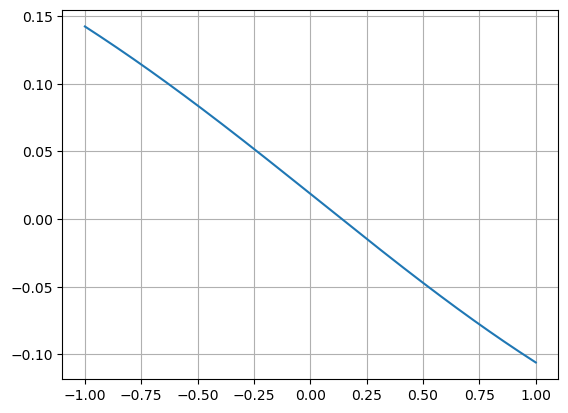

In [133]:
y_locations_test = model(input1[1].expand(len(input2_physics),-1),input2_physics.to(device))
plt.plot(x_locations.cpu().detach().numpy(),y_locations_test.cpu().detach().numpy()) 
plt.grid()       

In [134]:
input_time.size(0)

220

In [135]:
input2_BC1 = torch.cat((torch.zeros(input_time.size(0),1),input_time),-1).to(device)

In [136]:
target_BC1 = torch.zeros(input_time.size(0))

In [137]:
input2.size()

torch.Size([220, 2])

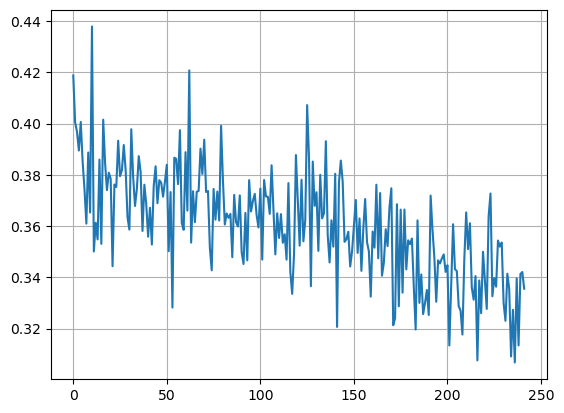

In [138]:
plt.plot(loss_rec)#[1000:])
plt.grid()

In [139]:
# model(y,torch.tensor([0,0]))